<a href="https://colab.research.google.com/github/VarshithaNuligonda/DL-ASSIGNMENT/blob/main/DL_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


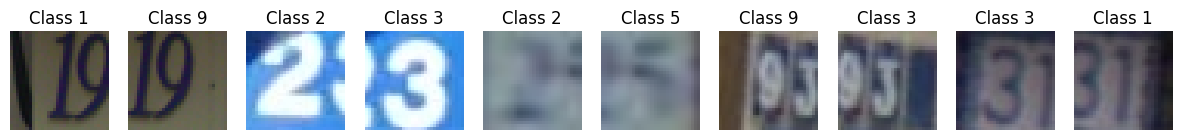

Epoch 1, Loss: 6182.6800, Train Acc: 51.06%, Val Acc: 65.82%
Epoch 2, Loss: 4249.3907, Train Acc: 68.51%, Val Acc: 68.89%
Epoch 3, Loss: 3810.9081, Train Acc: 71.93%, Val Acc: 72.07%
Epoch 4, Loss: 3553.9115, Train Acc: 73.99%, Val Acc: 73.74%
Epoch 5, Loss: 3376.1373, Train Acc: 75.20%, Val Acc: 74.71%
Test Accuracy: 72.23%


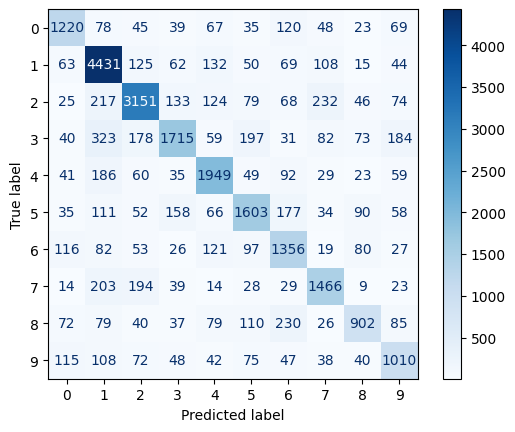

Cross-Entropy Loss: 1527.6991, MSE Loss: 15552.2723


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)


def show_sample_images(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(15, 4))
    for i in range(10):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[i].set_title(f'Class {label}')
        axes[i].axis('off')
    plt.show()

show_sample_images(train_dataset)


train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])


input_size = 32 * 32 * 3
hidden_layers = [32, 64, 128]
output_size = 10
learning_rate = 1e-4
num_epochs = 5
batch_size = 16
activation_fn = nn.ReLU
weight_decay = 0.5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class FFNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation_fn):
        super(FFNN, self).__init__()
        layers = []
        prev_size = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(prev_size, h))
            layers.append(activation_fn())
            prev_size = h
        layers.append(nn.Linear(prev_size, output_size))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)


model = FFNN(input_size, hidden_layers, output_size, activation_fn).to(device)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)


optimizer_type = "adam"

if optimizer_type == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'momentum':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
elif optimizer_type == 'nesterov':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
elif optimizer_type == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
elif optimizer_type == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == 'nadam':
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)


criterion = nn.CrossEntropyLoss()

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')


def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

train_model(model, criterion, optimizer, train_loader, val_loader, epochs=num_epochs)

# Test accuracy
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix
def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

plot_confusion_matrix(model, test_loader)

# Cross-Entropy vs MSE Loss Comparison
criterion_mse = nn.MSELoss()
def compare_losses(model, loader):
    model.eval()
    ce_loss, mse_loss = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            ce_loss += criterion(outputs, labels).item()
            labels_one_hot = torch.zeros_like(outputs).scatter_(1, labels.view(-1, 1), 1)
            mse_loss += criterion_mse(outputs, labels_one_hot).item()
    print(f'Cross-Entropy Loss: {ce_loss:.4f}, MSE Loss: {mse_loss:.4f}')

compare_losses(model, test_loader)
